In [4]:
def pixels_to_wavelenghts(pixel, slope, intercept):
    '''
    This function converts pixel values to wavelengths using a linear model to be determined by a fit.
    '''
    return slope * pixel + intercept

def import_files(path, filename):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the fit files, then for the filename choose something like bias* to obtain all bias files
    as a dictionary that can be accessed by filename 
    '''
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        file_dict[os.path.basename(file)] = fits.getdata(file) # key of the dict is the filename.

    headers_dict = dict()
    for x in file_dict.keys():
        headers_dict[x] = fits.getheader(path + x)

    return file_dict, headers_dict 

def get_peak_wavelength(wavelengths, irradiances):
    index = list(irradiances).index(max(irradiances))
    return  wavelengths[index]

def get_effective_temperature(wavelength_peak):
    return ( 2.897771955 * 10**-3 ) / (wavelength_peak * 10**-9)

def stack(values):
    return  np.median( [ x for x in values ], axis=0 )

def planck_scaled(temperature, wavelength):
    return (S := ( ( ( ac.R_sun / ac.au ) ** 2 )  *  ( 2 * sc.Planck * sc.speed_of_light ** 2 ) /
        ( (wavelength**5) * ( np.exp( ( sc.Planck * sc.speed_of_light) / ( wavelength * sc.k * temperature ) ) - 1 ) ) ) )


Import fraunhofer lines

In [5]:
df_fl = pd.read_csv('../data/fraunhofer_lines.csv')
df_fl.keys()

Index(['name', 'wavelength', 'pixel', 'intensity'], dtype='object')

In [6]:
flat_dict, flat_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/20211112 - LISA daglicht spectra/" ,
    "flat_alt*"
)

light_dict, light_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/" ,
    "skyspectrum*")

dark_dict, dark_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/" ,
    "Dark*"
)

bias_dict, bias_headers = import_files(
    "C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/SunsetLISA/" ,
    "bias*"
)

print(
    light_headers['skyspectrum zenit-0001.fit']['IMAGETYP'],
    flat_headers['flat_alt-0001.fit']['IMAGETYP'],
    dark_headers['Dark-0001.fit']['IMAGETYP'],
    bias_headers['bias-001.fit']['IMAGETYP'],
)

Light Frame Light Frame Dark Frame Bias Frame


### Calibration

<Parameter 'slope', value=0.25525659690182534 +/- 0.00116, bounds=[-inf:inf]>
<Parameter 'intercept', value=390.82847973147994 +/- 0.809, bounds=[-inf:inf]>


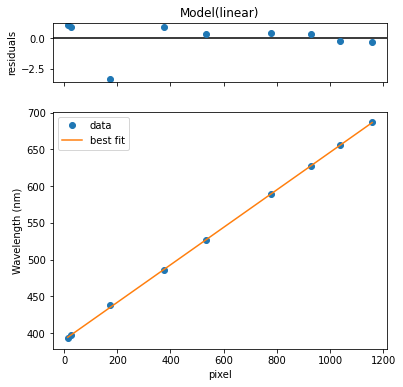

In [12]:
model = models.LinearModel()
fit_pixel_wavelength = model.fit(x=df_fl['pixel'], data=df_fl['wavelength'])
print(fit_pixel_wavelength.params['slope'])
print(fit_pixel_wavelength.params['intercept'])
fit_pixel_wavelength.plot(xlabel='pixel', ylabel='Wavelength (nm)')

In [14]:
fit_pixel_wavelength

### Stacking

TODO: Fix stacking, do it like the single file case below.

In [6]:
light_stack = stack( light_dict.values() )
bias_master = stack( bias_dict.values() )

In [7]:
flat_master = stack( [flat - bias_master for flat in flat_dict.values() ] )

In [8]:
flat_master = flat_master / np.median(flat_master) # scale flat_master

In [ ]:
#calibrated = [ (light - bias_master) / flat_master for light in light_stack ]

### Single fit file case 

In [51]:
flat = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/20211112 - LISA daglicht spectra/flat_alt-0001.fit" )
light = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/20201109 sky zenith/skyspectrum zenit-0001.fit" )

light_sum_before = np.sum (light, axis=0)
light_sum = np.sum( light - bias_master, axis=0)

flat_sum_before = np.sum (flat, axis=0)
flat_sum = np.sum( flat - bias_master, axis=0)

flat_scaled = flat_sum / np.median(flat_sum)
light_scaled = light_sum / flat_scaled


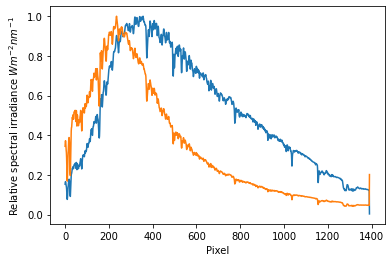

In [52]:
plt.ylabel("Relative spectral irradiance $Wm^{-2}nm^{-1}$")
plt.xlabel("Pixel")
plt.plot(light_sum / np.max(light_sum))
plt.plot(light_scaled / np.max(light_scaled))

In [ ]:
light_sum = np.sum( light_stack, axis=0)

In [ ]:
calibrated_sum = np.sum(calibrated, axis=0)

### Crude method to determine effective temperature.

In [ ]:
T_accepted = 5772
print(wavelength_peak := get_peak_wavelength(wavelengths, spectrum)) # 481.6998282285298
print(T_eff := get_effective_temperature(wavelength_peak)) # 6015.72137913495
print("%f%% error from the accepted value." % float( ( T_eff / T_accepted ) * 100 - 100) ) #4.22% error

In [ ]:
plt.xlabel('wavelength (nm)')
plt.ylabel('intensity (counts)')
plt.plot(wavelengths, spectrum)

In [ ]:
df = pd.DataFrame({'spectral irradiance' : spectrum, 'wavelength' : wavelengths})
df.to_csv("./data/to_fit.csv")

### Vega

In [53]:
flat = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics_non_git/solar_physics_data/NP2 zonnefysica/20211112 - LISA daglicht spectra/flat_alt-0001.fit" )
vega_light = fits.getdata("C:/Users/bvptr/academia/physics/year2/natuurkunde_en_sterrenkunde_practicum2/solar_physics/data/Vega-0005_2s.fit" )

vega_sum_before_bias = np.sum( vega_light, axis=0 )
vega_sum = np.sum( vega_light - bias_master, axis=0 )

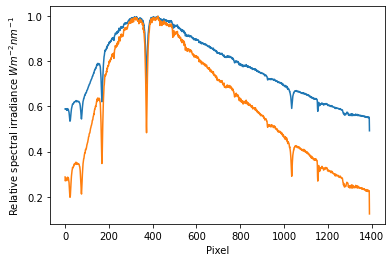

In [55]:
plt.ylabel("Relative spectral irradiance $Wm^{-2}nm^{-1}$")
plt.xlabel("Pixel")
plt.plot(vega_sum_before_bias / np.max(vega_sum_before_bias))
plt.plot(vega_sum / np.max(vega_sum))